# Agglomerative Clustering - 聚合式分群(階層分群 bottom up)

1. 官網認為的usecase: Many clusters, possibly connectivity constraints, non Euclidean distances
2. 簡單步驟
    1. 將每筆資料視為一個群聚 Ci, i=1 1 to n.
    2. 找出所有群聚間，距離最接近的兩個群聚 Ci、Cj
    3. 合併 Ci、 Cj 成為一個新的群聚
    4. 假如目前的群聚數目多於我們預期的群聚數目，則反覆重複步驟二至四，直到群聚數目已將降到我們所要求的數目。
3. 群之間的距離有3種
   - complete: 兩群間最遠的
   - average: 兩群間pairwise去算兩兩距離加起來取平均
   - ward: 沃德法, 兩群的平均點找出來, 兩群先看成一群, 群內每個點跟"平均點"的距離加起來取平均
4. 需要事先指定群數
5. 用途: 一般性分群用, 無法支援大量資料...

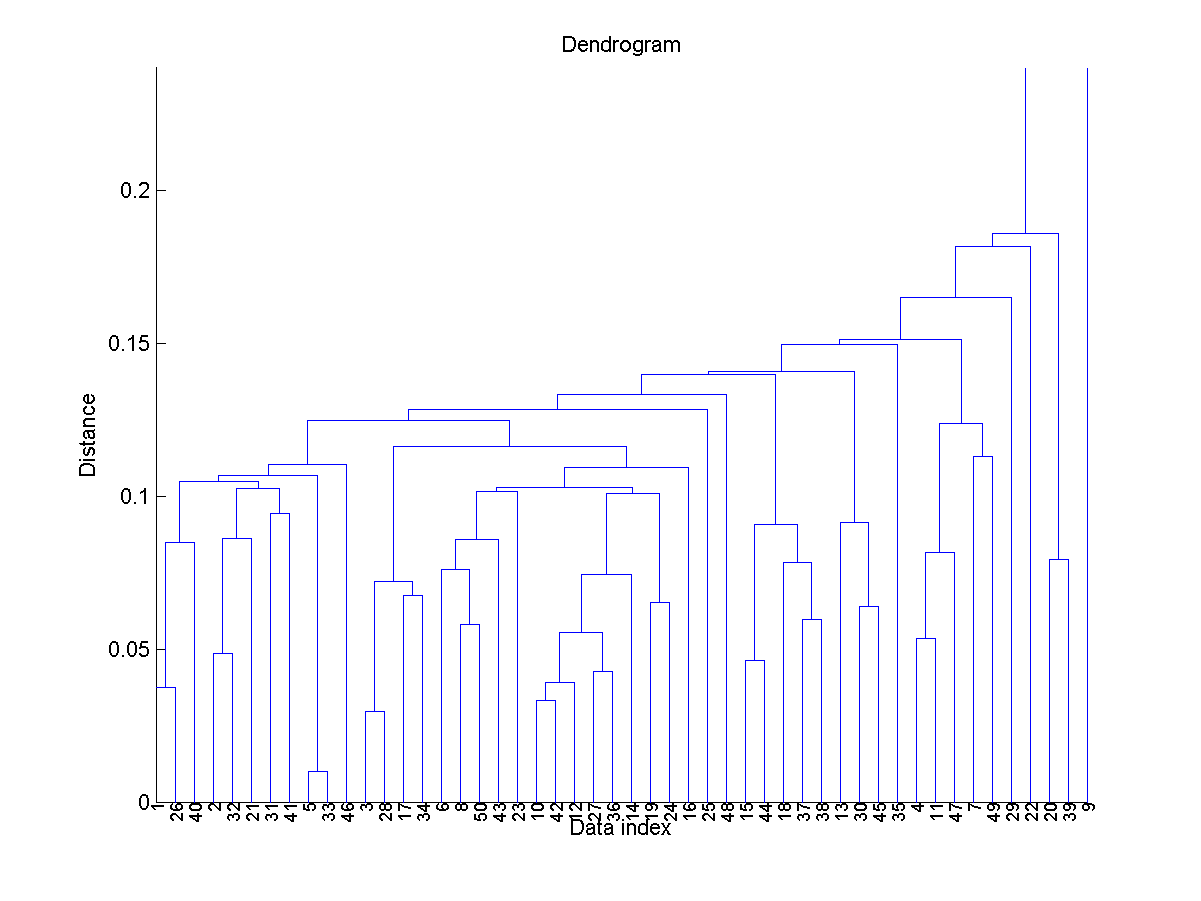

In [6]:
from IPython.display import Image
Image('Agglomerative.png')

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 抓出頻果新聞資料
apple78Df = None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
apple78Df

,forum,subject,term,keyword,content,pageurl
0,politics,軍人虐狗 國防部長上莒光園地：絕不容許再發生,更新 影片 海軍陸戰隊 事件 國防部長 馮世寬 火線 道歉 莒光 馮世寬 官兵 殘忍 國軍 ...,馮世寬 馮世寬 馮世寬 馮世寬 馮世寬 生命 生命 生命 生命 生命 官兵 官兵 官兵 衛國...,（更新：新增影片） 海軍陸戰隊虐狗事件引發眾怒，國防部長馮世寬不但親上火線道歉，今天「莒光園...,http://www.appledaily.com.tw/realtimenews/arti...
1,entertainment,田馥甄舉杯慶《日常》 佼佼：小心變張清芳,新聞 田馥甄 Hebe 記者會 現場 斯洛伐克 家居 模樣 日常生活 專輯 日常 曲目 曝光...,田馥甄 田馥甄 田馥甄 田馥甄 專輯 專輯 專輯 專輯 專輯 日常生活 日常生活 日常生活 ...,(新增動新聞) 田馥甄（Hebe）今舉辦發片記者會，現場打造斯洛伐克家居模樣，展現出她的日常...,http://www.appledaily.com.tw/realtimenews/arti...
2,fashion,Rimowa聯名蕭青陽騎白馬 徐佳瑩歌聲助陣,新聞 德國 行李箱 品牌 發表 台灣 設計師 青陽 合作 台灣 青陽 作品 白馬 靈感 設計...,青陽 青陽 青陽 青陽 青陽 青陽 青陽 青陽 徐佳瑩 徐佳瑩 徐佳瑩 白馬 白馬 白馬 作...,（新增動新聞） 德國知名行李箱品牌Rimowa，發表首次與台灣設計師蕭青陽合作的台灣獨賣限定...,http://www.appledaily.com.tw/realtimenews/arti...
3,fashion,【女神進化】天心戴蛇形陀飛輪錶 許願升級魅惑術,新聞 天心 金融業 男友 分手 寶格麗 BVLGARI 發表 珠寶 許願 個性 女人 學習 ...,serpenti serpenti serpenti serpenti serpenti s...,（新增動新聞）天心和金融業男友剛分手，今為寶格麗（BVLGARI）發表Serpenti新珠寶...,http://www.appledaily.com.tw/realtimenews/arti...
4,property,房仲6月交易價量 雙北市逆轉勝,影片 房仲 房市 交易 台灣 逆轉勝 永慶 房產 集團 中心 全台 房市 交易量 北市 桃園...,交易量 交易量 交易量 交易量 北市 北市 北市 北市 北市 台南 台南 台南 台南 房市 ...,(新增：影片) 各家房仲發布6月房市交易現況，出現北台灣「逆轉勝」。其中，永慶房產集團研展中...,http://www.appledaily.com.tw/realtimenews/arti...
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
6,politics,巴拉圭農牧業者：希望高品質牛肉 供應台灣家庭,更新 影片 巴拉圭 鄉村 協會 時間 中午 款待 台灣 總統 蔡英文 巴拉圭 副總統 法拉 ...,巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉圭 巴拉...,（更新：新增影片）巴拉圭鄉村協會在當地時間30日中午設宴款待台灣總統蔡英文，巴拉圭副總統艾法...,http://www.appledaily.com.tw/realtimenews/arti...
7,life,台北-台中天天通勤 高鐵哥告訴你真相,更新 影片 高鐵 生活 高鐵 天天 通勤 交通工具 網友 MOBILE01 台中 台北 天天...,高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 高鐵 公司 公司 公司 公司 公司 公司 公司 公...,（更新：新增影片）高鐵可以達成各地生活一日圈，但問題是高鐵雖然快又方便，卻能當成「天天」通勤...,http://www.appledaily.com.tw/realtimenews/arti...
8,local,夜偷24斤生猛海鮮 門把留1枚指紋落網,更新 影像 影片 新北市 許姓 男子 清晨 金山區 台2線 海產 徒手 拉開 生鏽 欄杆 窗...,海產 海產 海產 海產 海產 金山區 金山區 指紋 指紋 許姓 許姓 黃酒 海螺 畫面 畫面...,(更新：增加內容、影像、影片)新北市30歲許姓男子，去年5月26日清晨5時許，見金山區台2線...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...


In [3]:
# 觀看下列分群, 有提供cosine distance, 效果一樣非常不好~
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances

vec = TfidfVectorizer(stop_words='english')
termMx = vec.fit_transform(apple78Df[:1000].term).toarray()
# distMx = cosine_distances(termMx)
model = AgglomerativeClustering(n_clusters=13, affinity='cosine', linkage='complete').fit(termMx)
pd.Series(model.labels_).value_counts()

1     162
11    136
0     112
12    107
7     106
10     88
2      56
9      44
3      44
6      38
8      37
4      37
5      33
dtype: int64

In [9]:
from sklearn import metrics

labels_true, labels = apple78Df[:1000].forum, model.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(termMx, labels))

Homogeneity: 0.293
Completeness: 0.282
V-measure: 0.287
Adjusted Rand Index: 0.162
Adjusted Mutual Information: 0.258
Silhouette Coefficient: 0.014


In [11]:
# 設定grp後可觀察分群的狀況, 群內的文章相似度並不像是同一群的...
grp = 1
pre1000 = apple78Df[:1000]
print(pre1000[(model.labels_ == grp)].forum.value_counts())
pre1000[(model.labels_ == grp)] # & (pre1000.forum == '3c')

sports           84
local            22
life             18
international    16
entertainment     7
fashion           6
forum             5
animal            1
3c                1
finance           1
strange           1
Name: forum, dtype: int64


,forum,subject,term,keyword,content,pageurl
5,sports,【強】王建民2局無失分 第5勝進帳,更新 更新 影片 比賽 皇家 終結者 戴維斯 Wade Davis 救援 延長 王建民 演出...,皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 皇家 王建民 ...,更新：新增球評說法 (更新影片)(更進比賽進度) 皇家終結者戴維斯(Wade Davis)本...,http://www.appledaily.com.tw/realtimenews/arti...
9,local,【專業文】分辨正港UA 專家有4招,更新 影片 智慧財產權 案件 刑事警察 大隊 高雄市 早市 攤商 仿冒 服飾 代理 隊長 蔡...,正品 正品 正品 正品 正品 正品 正品 正品 under under under unde...,（更新：新增影片）專責偵辦侵害智慧財產權案件的保二總隊刑事警察大隊，這次在高雄市區早市，查獲...,http://www.appledaily.com.tw/realtimenews/arti...
11,local,變態殺童男李靖 猥褻10少年判刑20年,更新 新聞 新竹市 林姓 小六 男童 命案 社會 檢警 發現 少年 李靖 猥褻 強制猥褻罪 ...,李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 李靖 少年 少年 少...,（更新：動新聞）新竹市林姓小六男童去年5月遭拐殺命案震驚社會，檢警事後陸續發現另有10名少年...,http://www.appledaily.com.tw/realtimenews/arti...
16,local,【更新】算什麼台灣之光 強國山寨UA標MIT,更新 網友 刑事警察 大隊 三民 三民路 早市 仿冒 Under Armour 運動 品牌 ...,仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 仿冒 服飾 服飾 服飾 服飾 服飾 服...,（更新：增加網友意見）保二總隊刑事警察大隊在高市三民區三民路早市，查獲仿冒UA（Under ...,http://www.appledaily.com.tw/realtimenews/arti...
17,international,【世界一瞬間】風大撩裙第一夫人怕怕,照片 千言萬語 蘋果日報 國內 精彩 新聞 照片 攝影 視角 看透 世界 角落 喜怒哀樂 關...,蜜雪兒 蜜雪兒 攝影 攝影 走光 裸女 車震 世界 世界 第一夫人 保守黨 大將 千言萬語 ...,一張照片勝過千言萬語！？《蘋果日報》搜集每天國內外各地最精彩的新聞照片，帶你透過優秀攝影者的...,http://www.appledaily.com.tw/realtimenews/arti...
20,sports,謝淑薇／莊佳容配取得里約奧運女雙參賽資格,中華民國 網球 協會 台灣 組合 謝淑薇 莊佳容 里約奧運 網球 等於 里約奧運 網球 謝淑...,網球 網球 網球 網球 網球 謝淑薇 謝淑薇 謝淑薇 教練 教練 教練 教練 代表 代表 代...,中華民國網球協會今證實，台灣女雙組合謝淑薇∕莊佳容確定取得里約奧運的網球女雙參賽資格，等於今...,http://www.appledaily.com.tw/realtimenews/arti...
35,life,由他所愛的學生 送大體老師最後一程,更新 影片 高醫大 大體老師 火化 儀式 大體老師 光復 國小 任教 心肌梗塞 妻子 遺願 ...,大體老師 大體老師 大體老師 大體老師 大體老師 大體老師 大體老師 光復 光復 光復 光復...,(更新：新增影片)高醫大今辦大體老師入斂與火化儀式，其中一位大體老師盧光復（56歲），生前在...,http://www.appledaily.com.tw/realtimenews/arti...
44,life,【更新】校務會議通過 北一女可穿短褲出入校門,更新 校方 校對 制服 高中生 制服 自主 台中女中 校務會議 開放 學生 運動 短褲 出校...,出校 出校 出校 出校 出校 出校 出校 出校 校服 校服 校服 校服 校服 校服 校服 校...,（更新：校方及各界說法）女校對制服的規定大多比較嚴格，近年越來越多女高中生爭取制服自主。今年...,http://www.appledaily.com.tw/realtimenews/arti...
47,life,吃完飯車上出現一隻雞 網友：宵夜有著落了,機車族 經驗 網友 臉書 社團 爆料公社 照片 照片 中一 黑色 安全帽 燒烤 餐廳 停車場...,安全帽 安全帽 安全帽 安全帽 宵夜 宵夜 爆料公社 爆料公社 爆料公社 網友 網友 網友 ...,相信很多機車族都曾遇過牽車時，愛車上多了「異物」的經驗。有網友在《臉書》不公開社團「爆料公社...,http://www.appledaily.com.tw/realtimenews/arti...
52,life,【苦勞網】暨大學生要求退回調漲案,網特 記者 若想 台北 報導 教育部 公告 學年度 大專 院校 調漲 暨南 國際 大學 台北...,調漲 調漲 調漲 大學 大學 大學 教育部 教育部 暨南 學店 暨南大學 網特 學生 學生 ...,本內容由苦勞網提供【苦勞網特約記者高若想∕台北報導】教育部於6月18日公告105學年度大專院...,http://www.appledaily.com.tw/realtimenews/arti...


estimated bandwidth: 0.717182537302


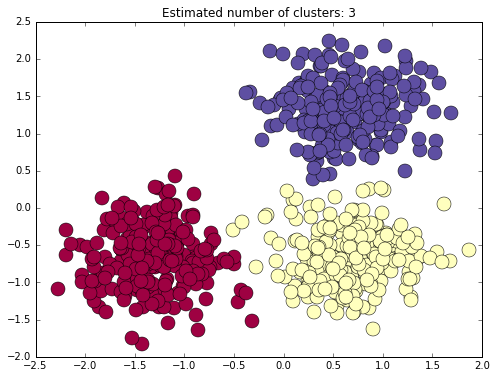

In [17]:
# 仿照DBSCAN的例子產生一樣的資料分群看看
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=750)
print('estimated bandwidth: {}'.format(bandwidth))
clf = AgglomerativeClustering(3)
clf.fit(X)
labels = clf.labels_

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % len(set(clf.labels_)))
plt.show()

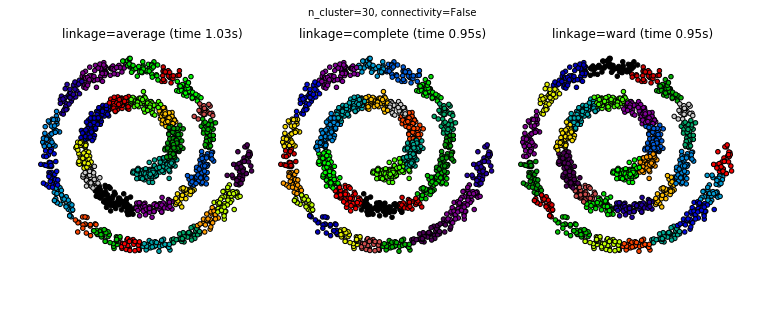

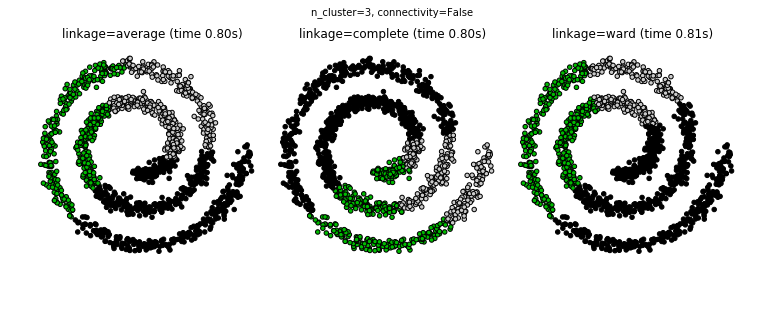

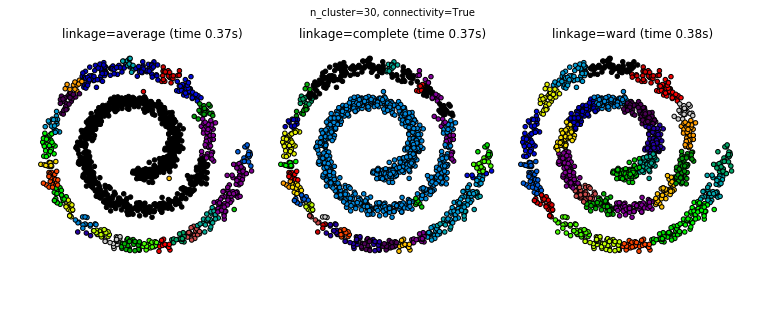

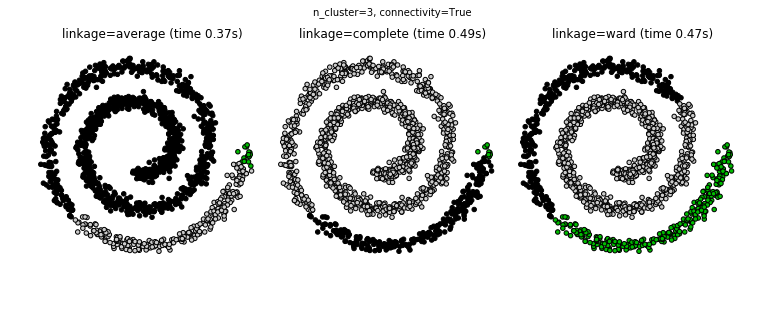

In [3]:
# 官網範例: 懂得可以分享一下...

# Authors: Gael Varoquaux, Nelle Varoquaux
# License: BSD 3 clause

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()